In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [3]:
!pip install surprise
!pip install AST

     |████████████████████████████████| 11.8MB 4.3MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670923 sha256=4da38e380a0ae216e23cee85d7e5d204afb3d9e17e447f6708d783b646fbcd1a
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [16]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
import ast
# from lenskit.crossfold import partition_users, SampleFrac
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import seaborn as sns
from collections import defaultdict

In [18]:
df = pd.read_csv('df_yelp_200K.csv')
df.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful_x',
       'funny_x', 'cool_x', 'text_x', 'date', 'Unnamed: 0_x', 'name_x',
       'review_count_x', 'yelping_since', 'useful_y', 'funny_y', 'cool_y',
       'elite', 'friends', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos', 'Unnamed: 0_y', 'name_y', 'address', 'city',
       'state', 'postal_code', 'latitude', 'longitude', 'stars',
       'review_count_y', 'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [19]:
data = df[['business_id','review_id','user_id','name_y','attributes','review_stars','friends','compliment_hot','compliment_more','compliment_cute','compliment_cool','compliment_funny','compliment_writer','compliment_photos']]
data.columns = ['business_id','review_id','user_id','Restaurant Name','Attributes','Rating','Friends','is_hot','is_more','is_cute','is_cool','is_funny','is_writer','is_photos']
data.columns

Index(['business_id', 'review_id', 'user_id', 'Restaurant Name', 'Attributes',
       'Rating', 'Friends', 'is_hot', 'is_more', 'is_cute', 'is_cool',
       'is_funny', 'is_writer', 'is_photos'],
      dtype='object')

In [20]:
print(data.shape)
data_att = data[data['Attributes'].notnull()]
# data_att = data
print(data_att.shape)

(231254, 14)
(230804, 14)


In [21]:
data_att['Attributes'] = data_att['Attributes'].apply(lambda x: ast.literal_eval(x))
data_att = pd.concat([data_att,data_att['Attributes'].apply(pd.Series)],axis=1)
data_att = data_att.drop(['Attributes'], axis=1)
print(data_att.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(230804, 50)


In [22]:
print(data_att.columns)
print(data_att.shape)
# data_att.isna().sum()
data_att = data_att[['business_id','review_id','user_id','Friends','Restaurant Name','Rating','GoodForKids','BikeParking','RestaurantsPriceRange2','WiFi','RestaurantsGoodForGroups','RestaurantsAttire','RestaurantsTakeOut','Alcohol','OutdoorSeating','Ambience','NoiseLevel','HasTV','is_hot','is_more','is_cute','is_cool','is_funny','is_writer','is_photos']]
print(data_att.columns)
data_att.head()

Index(['business_id', 'review_id', 'user_id', 'Restaurant Name', 'Rating',
       'Friends', 'is_hot', 'is_more', 'is_cute', 'is_cool', 'is_funny',
       'is_writer', 'is_photos', 'Caters', 'GoodForKids', 'BikeParking',
       'RestaurantsPriceRange2', 'WiFi', 'RestaurantsGoodForGroups',
       'RestaurantsAttire', 'RestaurantsTakeOut', 'Alcohol',
       'BusinessAcceptsCreditCards', 'GoodForMeal', 'BusinessParking',
       'OutdoorSeating', 'RestaurantsReservations', 'Ambience', 'NoiseLevel',
       'RestaurantsDelivery', 'RestaurantsTableService', 'DogsAllowed',
       'HappyHour', 'HasTV', 'Music', 'BestNights', 'GoodForDancing',
       'BYOBCorkage', 'Corkage', 'CoatCheck', 'WheelchairAccessible',
       'BusinessAcceptsBitcoin', 'ByAppointmentOnly', 'Smoking', 'DriveThru',
       'BYOB', 'DietaryRestrictions', 'AgesAllowed', 'AcceptsInsurance',
       'Open24Hours'],
      dtype='object')
(230804, 50)
Index(['business_id', 'review_id', 'user_id', 'Friends', 'Restaurant Name',
   

,business_id,review_id,user_id,Friends,Restaurant Name,Rating,GoodForKids,BikeParking,RestaurantsPriceRange2,WiFi,RestaurantsGoodForGroups,RestaurantsAttire,RestaurantsTakeOut,Alcohol,OutdoorSeating,Ambience,NoiseLevel,HasTV,is_hot,is_more,is_cute,is_cool,is_funny,is_writer,is_photos
0,J8GuDrqeLH1xMpSpeEixYA,G1rbhEyMUVnFIq1kAT8jCg,nIJD_7ZXHq-FX8byPMOkMQ,"B5vnnBub9sscTix_tPAwUw, FKFWX9kiyTvJY8_P9j_Rmw...",Biscuits,2.0,True,True,1,'no',True,u'casual',True,u'none',False,"{'romantic': False, 'intimate': False, 'touris...",u'average',False,0,0,1,0,0,0,0
1,J8GuDrqeLH1xMpSpeEixYA,OtH9uCUr5e2Kz12F1LboXA,pu_AQig2fw40PshvtgONPQ,"SCo1UBoeN3bhRMkSYuiX1A, rA97zeqOrUYuEM69n0Xn4w...",Biscuits,2.0,True,True,1,'no',True,u'casual',True,u'none',False,"{'romantic': False, 'intimate': False, 'touris...",u'average',False,26,8,4,58,58,28,6
2,J8GuDrqeLH1xMpSpeEixYA,UcQhHkWR8YfIOWeLzjflNA,xUhKi3p2BRTEbTHtJz-Hhg,"FHAVmMKWq6sJoiiUXxHGsA, TSpAeuGiXrzTXpSdk35CBw...",Biscuits,4.0,True,True,1,'no',True,u'casual',True,u'none',False,"{'romantic': False, 'intimate': False, 'touris...",u'average',False,0,0,0,0,0,0,0
3,J8GuDrqeLH1xMpSpeEixYA,IJj3by6GI9jV8d5wI46Taw,Vv1jaDcK9fdaqGwODB0AcA,"klIN1493a7XioyRXqZHBaQ, thaI8-KSPoMXQe3lOrUA6g...",Biscuits,3.0,True,True,1,'no',True,u'casual',True,u'none',False,"{'romantic': False, 'intimate': False, 'touris...",u'average',False,0,1,0,4,4,4,0
4,J8GuDrqeLH1xMpSpeEixYA,ynCKeNNCL76ws3W3AtbAKQ,ZefHQwjj3b7mxi46oKik-g,"SArE5Yd9m6oeCvr6AUOsRw, jjIzxPqFMLsUccPG2Fuvog...",Biscuits,3.0,True,True,1,'no',True,u'casual',True,u'none',False,"{'romantic': False, 'intimate': False, 'touris...",u'average',False,0,0,0,0,0,0,0


In [23]:
data_att = data_att[data_att['Ambience'].notnull()]
data_att['Ambience'] = data_att['Ambience'].apply(lambda x: ast.literal_eval(x))
data_att = pd.concat([data_att,data_att['Ambience'].apply(pd.Series)],axis=1)
print(data_att.shape)
data_att = data_att.drop(['Ambience'], axis=1)
print(data_att.shape)
print(data_att.columns)

(213378, 34)
(213378, 33)
Index(['business_id', 'review_id', 'user_id', 'Friends', 'Restaurant Name',
       'Rating', 'GoodForKids', 'BikeParking', 'RestaurantsPriceRange2',
       'WiFi', 'RestaurantsGoodForGroups', 'RestaurantsAttire',
       'RestaurantsTakeOut', 'Alcohol', 'OutdoorSeating', 'NoiseLevel',
       'HasTV', 'is_hot', 'is_more', 'is_cute', 'is_cool', 'is_funny',
       'is_writer', 'is_photos', 'romantic', 'intimate', 'touristy', 'hipster',
       'divey', 'classy', 'trendy', 'upscale', 'casual'],
      dtype='object')


In [24]:
def convert_type(df, colname, category='category'):
  df[colname] = df[colname].astype(category)
  return df

# for i in range(5, len(data_att.columns)):
#   data_att = convert_type(data_att,data_att.columns[i])

In [25]:
# data_att.isna().sum()

In [26]:
def clean_wifi(x):

  if type(x) == str:
    if "no" in x:
      return "no"
    if "free" in x:
      return "free"
    if "paid" in x:
      return "paid"

  return 'None'

def clean_attire(x):

  if type(x) == str:
    if "casual" in x:
      return "casual"
    if "dressy" in x:
      return "dressy"
    if "formal" in x:
      return "formal"

  return 'None'

def clean_alcohol(x):

  if type(x) == str:
    if "beer" in x:
      return "beer_and_wine"
    if "full" in x:
      return "full_bar"

  return 'None'

def clean_noise(x):

  if type(x) == str:
    if "average" in x:
      return "average"
    if "very" in x:
      return "very_loud"
    if "loud" in x:
      return "loud"
    if "quiet" in x:
      return "quiet"

  return 'None'

In [27]:
# wifi, attire, alcohol, noiselevel
# test = data_att[data_att['WiFi'].notnull()]
# print("no" in test['WiFi'].iloc[0])
# test[test['WiFi'].str.contains('free')]['WiFi'].value_counts()


data_att['WiFi'] = data_att['WiFi'].apply(lambda x: clean_wifi(x))#.astype('category')
data_att['RestaurantsAttire'] = data_att['RestaurantsAttire'].apply(lambda x: clean_attire(x))#.astype('category')
data_att['Alcohol'] = data_att['Alcohol'].apply(lambda x: clean_alcohol(x))#.astype('category')
data_att['NoiseLevel'] = data_att['NoiseLevel'].apply(lambda x: clean_noise(x))#.astype('category')


In [29]:
data_att['Friends'] = data_att['Friends'].apply(lambda x: len(x.split(",")))
data_att.columns

Index(['business_id', 'review_id', 'user_id', 'Friends', 'Restaurant Name',
       'Rating', 'GoodForKids', 'BikeParking', 'RestaurantsPriceRange2',
       'WiFi', 'RestaurantsGoodForGroups', 'RestaurantsAttire',
       'RestaurantsTakeOut', 'Alcohol', 'OutdoorSeating', 'NoiseLevel',
       'HasTV', 'is_hot', 'is_more', 'is_cute', 'is_cool', 'is_funny',
       'is_writer', 'is_photos', 'romantic', 'intimate', 'touristy', 'hipster',
       'divey', 'classy', 'trendy', 'upscale', 'casual'],
      dtype='object')

In [42]:
# data_att['casual'].value_counts()

True     150199
False     60405
Name: casual, dtype: int64

In [14]:
# data_att[data_att.select_dtypes(['category']).columns] = data_att[data_att.select_dtypes(['category']).columns].apply(lambda x: x.cat.codes)
# data_att = data_att.drop(['Ambience'],axis=1)

In [15]:
# data_att['Friends'].median()

23.0

In [26]:
data_att.to_csv('contextual_data.csv')

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


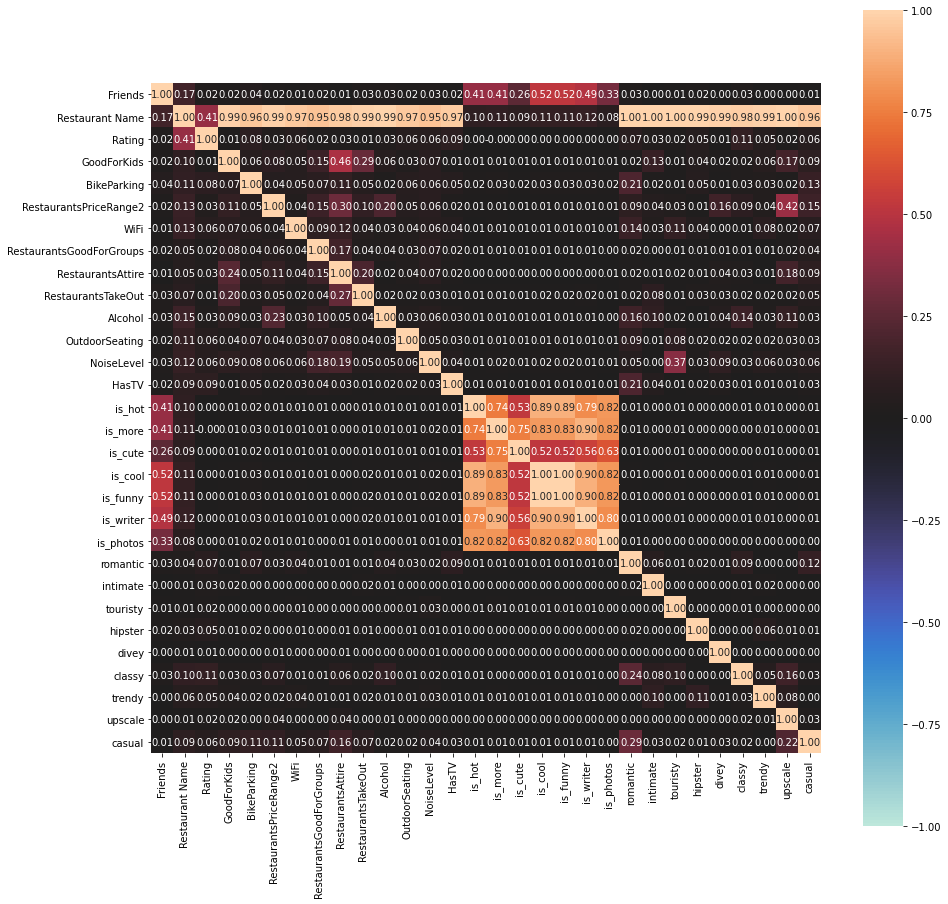

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fd1419a9978>,
 'corr':                            Friends  Restaurant Name  ...   upscale    casual
 Friends                   1.000000         0.166286  ...  0.001008  0.010663
 Restaurant Name           0.166286         1.000000  ...  1.000000  0.963023
 Rating                    0.024493         0.410752  ...  0.015289  0.055119
 GoodForKids               0.017835         0.097742  ...  0.173734  0.090756
 BikeParking               0.041571         0.106206  ...  0.017019  0.130940
 RestaurantsPriceRange2    0.017639         0.133008  ...  0.417145  0.150369
 WiFi                      0.009278         0.130913  ...  0.015733  0.069058
 RestaurantsGoodForGroups  0.016906         0.052407  ...  0.018004  0.039367
 RestaurantsAttire         0.005628         0.049509  ...  0.178441  0.086940
 RestaurantsTakeOut        0.027911         0.067920  ...  0.017468  0.051711
 Alcohol                   0.028452         0.148793  ...  0.109636 

In [44]:
import dython
features_numeric = data_att[['Friends', 'Restaurant Name',
       'Rating', 'GoodForKids', 'BikeParking', 'RestaurantsPriceRange2',
       'WiFi', 'RestaurantsGoodForGroups', 'RestaurantsAttire',
       'RestaurantsTakeOut', 'Alcohol', 'OutdoorSeating', 'NoiseLevel',
       'HasTV', 'is_hot', 'is_more', 'is_cute', 'is_cool', 'is_funny',
       'is_writer', 'is_photos', 'romantic', 'intimate', 'touristy', 'hipster',
       'divey', 'classy', 'trendy', 'upscale', 'casual']]
dython.nominal.associations(features_numeric, theil_u=True, figsize=(15, 15))
# cor = features_numeric.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [ ]:
pca_dep = PCA()
dep_reduced = pca_dep.fit_transform(features_numeric)
#print(pca_dep.explained_variance_ratio_)
np.cumsum(np.round(pca_dep.explained_variance_ratio_, decimals=4)*100)

array([ 21.89,  39.97,  53.49,  64.2 ,  73.59,  81.48,  86.88,  91.62,
        95.39,  98.41, 100.01])

Text(0, 0.5, 'Explained variance')

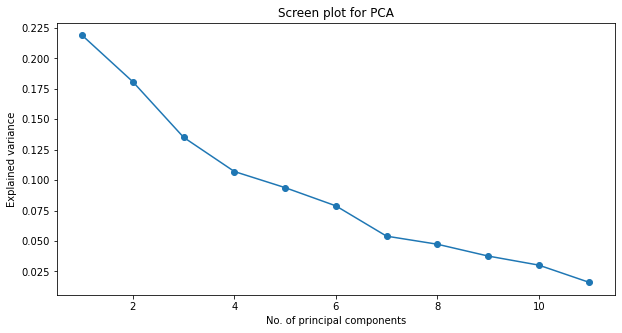

In [ ]:
plt.figure(1, figsize=(10, 5))
plt.plot(range(1,len(pca_dep.components_)+1),pca_dep.explained_variance_ratio_,'-o')
plt.axis('tight')
plt.title('Screen plot for PCA')
plt.xlabel('No. of principal components')
plt.ylabel('Explained variance')